## Importing Required libraries

In [47]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
import torch.nn.functional as F
import time
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, accuracy_score
import seaborn as sns
from sklearn.metrics import roc_curve, auc

## Loading and  the Dataset

In [48]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1), 
    transforms.Resize((28, 28)),  
    transforms.ToTensor(),  
    transforms.Normalize((0.5,), (0.5,))  
])

dataset = datasets.ImageFolder(root='datasets/cnn_dataset', transform=transform)
batch_size = 64
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

## Analysing and Visualizing dataset

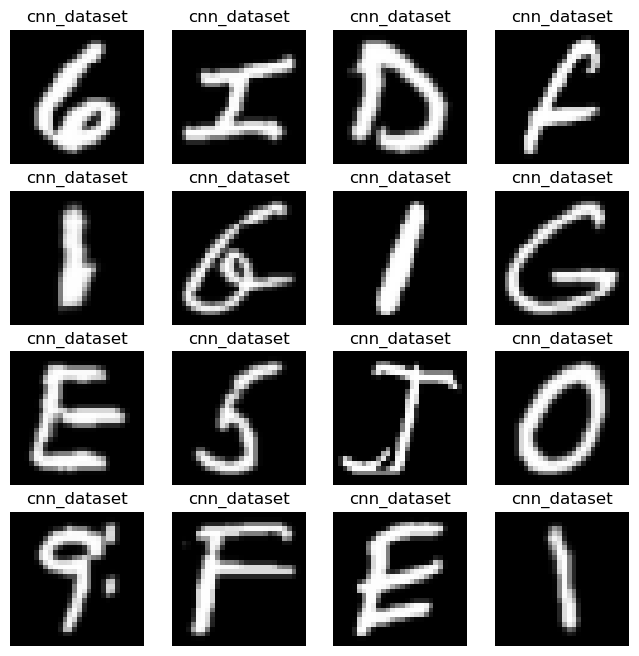

In [49]:
data_iter = iter(data_loader)
images, labels = next(data_iter)

plt.figure(figsize=(8, 8))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].squeeze(), cmap='gray')  
    plt.title(dataset.classes[labels[i]]) 
    plt.axis('off') 
plt.show()


## Splitting the dataset into training and testing

In [50]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

train_indices, test_indices = train_test_split(range(len(dataset)), test_size=0.2, stratify=dataset.targets)

train_indices, val_indices = train_test_split(train_indices, test_size=0.2, stratify=[dataset.targets[i] for i in train_indices])

train_subset = Subset(dataset, train_indices)
val_subset = Subset(dataset, val_indices)
test_subset = Subset(dataset, test_indices)

train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)

print(f"Training samples: {len(train_subset)}")
print(f"Validation samples: {len(val_subset)}")
print(f"Test samples: {len(test_subset)}")


Training samples: 38876
Validation samples: 9720
Test samples: 12149


## Basic CNN Architecture

## CNN Model

In [51]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)  
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1) 
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1) 
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2) 

        self.fc1 = nn.Linear(128 * 3 * 3, 512) 
        self.fc2 = nn.Linear(512, 36) 
        
        # Dropout
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) 
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x))) 
        
        x = x.view(-1, 128 * 3 * 3)
        
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x) 

        return x

## Summary of the model

In [52]:
model = SimpleCNN()
summary(model, (1, 28, 28)) 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
         MaxPool2d-2           [-1, 32, 14, 14]               0
            Conv2d-3           [-1, 64, 14, 14]          18,496
         MaxPool2d-4             [-1, 64, 7, 7]               0
            Conv2d-5            [-1, 128, 7, 7]          73,856
         MaxPool2d-6            [-1, 128, 3, 3]               0
            Linear-7                  [-1, 512]         590,336
           Dropout-8                  [-1, 512]               0
            Linear-9                   [-1, 36]          18,468
Total params: 701,476
Trainable params: 701,476
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.42
Params size (MB): 2.68
Estimated Total Size (MB): 3.10
-------------------------------------------

## Training the Model

In [ ]:
criterion = nn.CrossEntropyLoss()  
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train_model(model, train_loader, val_loader, epochs=10):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    
    start_time = time.time()
    
    for epoch in range(epochs):
        model.train()  
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in train_loader:
            optimizer.zero_grad() 
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(correct / total * 100)
        
        model.eval()  
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(val_correct / val_total * 100)
        
        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.2f}%, Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracies[-1]:.2f}%")
    
    time_taken = time.time() - start_time
    print(f"Training complete in {time_taken // 60}m {time_taken % 60:.0f}s")
    
    return train_losses, train_accuracies, val_losses, val_accuracies

train_losses, train_accuracies, val_losses, val_accuracies = train_model(model, train_loader, val_loader, epochs=10)


Epoch [1/10], Train Loss: 0.0150, Train Accuracy: 99.84%, Val Loss: 0.0000, Val Accuracy: 100.00%


## Model1 - Data Augmentation

In [ ]:
transform_augment = transforms.Compose([
    transforms.RandomResizedCrop(28),
    transforms.RandomHorizontalFlip(), 
    transforms.RandomRotation(30),     
    transforms.ToTensor(),             
    transforms.Normalize((0.5,), (0.5,)) 
])

class CNNWithDataAugmentation(nn.Module):
    def __init__(self):
        super(CNNWithDataAugmentation, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * 3 * 3, 512)
        self.fc2 = nn.Linear(512, 36)  

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 3 * 3)  
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

def train_model(model, train_loader, val_loader, optimizer, criterion, epochs=10):
    model.train()
    
    train_accuracies = []
    val_accuracies = []
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_accuracy = correct_train / total_train
        train_accuracies.append(train_accuracy)
        train_losses.append(train_loss)

        model.eval()  
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_loss = running_val_loss / len(val_loader)
        val_accuracy = correct_val / total_val
        val_accuracies.append(val_accuracy)
        val_losses.append(val_loss)

        print(f'Epoch [{epoch+1}/{epochs}], '
              f'Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}, '
              f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

    return model, train_accuracies, val_accuracies, train_losses, val_losses

model_augment = CNNWithDataAugmentation()
optimizer = optim.Adam(model_augment.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

epochs = 10
model_augment, aug_train_accuracies, aug_val_accuracies, aug_train_losses, aug_val_losses = train_model(
    model_augment, train_loader, val_loader, optimizer, criterion, epochs=epochs
)

## Model2: Learning Rate Scheduler

In [ ]:
model_lr = SimpleCNN()

optimizer = optim.Adam(model_lr.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=5, gamma=0.7)  

model_lr, lr_train_accuracies, lr_val_accuracies, lr_train_losses, lr_val_losses = train_model(
    model_augment, train_loader, val_loader, optimizer, criterion, epochs=epochs
)


## Model3: Batch Normalization

In [ ]:
class CNNWithBatchNormalization(nn.Module):
    def __init__(self):
        super(CNNWithBatchNormalization, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * 3 * 3, 512)
        self.fc2 = nn.Linear(512, 36)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = x.view(-1, 128 * 3 * 3)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model_bn = CNNWithBatchNormalization()
optimizer = optim.Adam(model_bn.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

model_bn, bn_train_accuracies, bn_val_accuracies, bn_train_losses, bn_val_losses = train_model(
    model_augment, train_loader, val_loader, optimizer, criterion, epochs=epochs
)

## Saving the Best model

In [ ]:
if accuracy_augment > accuracy_lr and accuracy_augment > accuracy_bn:
    torch.save(model_augment.state_dict(), 'best_model.pth')
    model = model_augment
    train_accuracies = aug_train_accuracies
    val_accuracies = aug_val_accuracies
    train_losses = aug_train_losses
    val_losses = aug_val_losses
elif accuracy_lr > accuracy_augment and accuracy_lr > accuracy_bn:
    torch.save(model_lr.state_dict(), 'best_model.pth')
    model = model_lr
    train_accuracies = lr_train_accuracies
    val_accuracies = lr_val_accuracies
    train_losses = lr_train_losses
    val_losses = lr_val_losses
else:
    torch.save(model_bn.state_dict(), 'best_model.pth')
    model = model_bn
    train_accuracies = bn_train_accuracies
    val_accuracies = bn_val_accuracies
    train_losses = bn_train_losses
    val_losses = bn_val_losses

## Evaluating the model on test data

In [ ]:
def evaluate_model(model, test_loader, criterion, device):
    model.eval()  
    correct = 0
    total = 0
    running_loss = 0.0
    all_labels = []
    all_preds = []
    start_time = time.time()

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)

            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    end_time = time.time()
    evaluation_time = end_time - start_time
    
    accuracy = accuracy_score(all_labels, all_preds)
    
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
    
    conf_matrix = confusion_matrix(all_labels, all_preds)
    
    fpr, tpr, thresholds = roc_curve(all_labels, all_preds, pos_label=1)
    roc_auc = auc(fpr, tpr)

    avg_loss = running_loss / len(test_loader)
    
    return accuracy, precision, recall, f1, avg_loss, evaluation_time, conf_matrix, fpr, tpr, roc_auc

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)  

criterion = torch.nn.CrossEntropyLoss()

test_accuracy, precision, recall, f1, test_loss, evaluation_time, conf_matrix, fpr, tpr, roc_auc = evaluate_model(model, test_loader, criterion, device)

print(f"Evaluation Time: {evaluation_time:.4f} seconds")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Test Loss: {test_loss:.4f}")
print(f"Confusion Matrix:\n{conf_matrix}")

## Visualization

### Training, Validation, and Test Accuracy

In [ ]:
epochs = 10
test_accuracies = [test_accuracy] * epochs

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accuracies, label='Training Accuracy', color='blue', marker='o')
plt.plot(epochs, val_accuracies, label='Validation Accuracy', color='orange', marker='s')
plt.plot(epochs, test_accuracies, label='Test Accuracy', color='green', linestyle='--')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training, Validation and Test Accuracy')
plt.legend(loc='best')
plt.grid(True)
plt.show()


### Training, Validation, and Test Loss

In [ ]:
test_losses = [test_loss] * epochs

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label='Training Loss', color='blue', marker='o')
plt.plot(epochs, val_losses, label='Validation Loss', color='orange', marker='s')
plt.plot(epochs, test_losses, label='Test Loss', color='green', linestyle='--')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training, Validation and Test Loss')
plt.legend(loc='best')
plt.grid(True)
plt.show()


### Confusion Matrix

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['True 0', 'True 1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### ROC Curve

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='b', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()